In [3]:
# ----------------------------------------------------
# B. IMPORT REQUIRED LIBRARIES
# ----------------------------------------------------
!pip3 install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import re


  Using cached pandas-2.2.3-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 1.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 1.4 MB/s eta 0:00:0000:0100:010m


Matplotlib is building the font cache; this may take a moment.


In [4]:
# ----------------------------------------------------
# C. LOAD DATASET
# ----------------------------------------------------
# 1. Upload via sidebar or use Drive path. Example:
file_path = '/home/luuketheone/Desktop/iiccn2-s4/ai_cs/BLADE/synthetic_detailed_logs.csv'
# 2. Read CSV into DataFrame:
df = pd.read_csv(file_path)
# 3. Quick shape and head:
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (100000, 19)


,timestamp_str,hostname,process,pid,user,source_ip,source_port,dest_ip,dest_port,protocol,command,file_path,action,status,tty,session_id,message,raw_log,label
0,2025-05-02 16:42:55,srv02,sshd,42086,user10,10.0.0.86,51690.0,NaN,NaN,NaN,NaN,NaN,NaN,Accepted,NaN,NaN,Accepted password for user10 from 10.0.0.86 po...,May 02 16:42:55 srv02 sshd[42086]: Accepted pa...,0
1,2025-05-02 16:47:32,kali,kernel,102868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USB DEVICE DETECTED,NaN,NaN,usb 5-3: new high-speed USB device number 4 us...,May 02 16:47:32 kali kernel[102868]: usb 5-3: ...,0
2,2025-05-02 16:48:09,kali,dpkg,301836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PACKAGE UNPACKING,NaN,NaN,Unpacking openssl (10.11.11) over (...),May 02 16:48:09 kali dpkg[301836]: Unpacking o...,0
3,2025-05-02 16:49:27,srv02,audit,275178,user9,10.0.0.43,NaN,NaN,NaN,NaN,NaN,/var/backups,read,Accessed,pts/1,53.0,"op=read path=""/var/backups"" hostname=srv02 add...",May 02 16:49:27 srv02 audit[275178]: USER_ACCT...,1
4,2025-05-02 16:51:04,srv03,firewalld,214041,NaN,10.0.0.78,NaN,130.230.11.241,443.0,UDP,NaN,NaN,NaN,ACCEPT,NaN,NaN,ACCEPT UDP 10.0.0.78:55378 -> 130.230.11.241:443,May 02 16:51:04 srv03 firewalld[214041]: ACCEP...,0


In [5]:
# ----------------------------------------------------
# D. INITIAL EXPLORATION
# ----------------------------------------------------
# 1. Summary stats:
print(df.describe(include='all'))
# 2. Data types & missing counts:
print(df.info())

              timestamp_str     hostname process            pid   user  \
count                100000       100000  100000  100000.000000  86568   
unique               100000            7      14            NaN     13   
top     2025-10-24 09:27:08  workstation  kernel            NaN   root   
freq                      1        14473   20030            NaN  11706   
mean                    NaN          NaN     NaN  248697.767900    NaN   
std                     NaN          NaN     NaN  144398.620656    NaN   
min                     NaN          NaN     NaN     100.000000    NaN   
25%                     NaN          NaN     NaN  123891.500000    NaN   
50%                     NaN          NaN     NaN  247143.000000    NaN   
75%                     NaN          NaN     NaN  374555.000000    NaN   
max                     NaN          NaN     NaN  499996.000000    NaN   

        source_ip   source_port         dest_ip     dest_port protocol  \
count       58500  33220.000000      

In [6]:
# ----------------------------------------------------
# E. DATA CLEANING & PREPROCESSING
# ----------------------------------------------------
# 1. Drop duplicates
df.drop_duplicates(inplace=True)
# 2. Drop rows missing raw_log or label
df.dropna(subset=['raw_log','label'], inplace=True)
# 3. Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp_str'], format='%Y-%m-%d %H:%M:%S')
# 4. Ensure label is integer
df['label'] = df['label'].astype(int)
# 5. Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
# 6. Apply preprocessing to raw_log
df['clean_log'] = df['raw_log'].apply(preprocess_text)

df.head()

,timestamp_str,hostname,process,pid,user,source_ip,source_port,dest_ip,dest_port,protocol,...,file_path,action,status,tty,session_id,message,raw_log,label,timestamp,clean_log
0,2025-05-02 16:42:55,srv02,sshd,42086,user10,10.0.0.86,51690.0,NaN,NaN,NaN,...,NaN,NaN,Accepted,NaN,NaN,Accepted password for user10 from 10.0.0.86 po...,May 02 16:42:55 srv02 sshd[42086]: Accepted pa...,0,2025-05-02 16:42:55,may 02 16 42 55 srv02 sshd accepted password f...
1,2025-05-02 16:47:32,kali,kernel,102868,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,USB DEVICE DETECTED,NaN,NaN,usb 5-3: new high-speed USB device number 4 us...,May 02 16:47:32 kali kernel[102868]: usb 5-3: ...,0,2025-05-02 16:47:32,may 02 16 47 32 kali kernel usb 5 3 new high s...
2,2025-05-02 16:48:09,kali,dpkg,301836,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,PACKAGE UNPACKING,NaN,NaN,Unpacking openssl (10.11.11) over (...),May 02 16:48:09 kali dpkg[301836]: Unpacking o...,0,2025-05-02 16:48:09,may 02 16 48 09 kali dpkg unpacking openssl 10...
3,2025-05-02 16:49:27,srv02,audit,275178,user9,10.0.0.43,NaN,NaN,NaN,NaN,...,/var/backups,read,Accessed,pts/1,53.0,"op=read path=""/var/backups"" hostname=srv02 add...",May 02 16:49:27 srv02 audit[275178]: USER_ACCT...,1,2025-05-02 16:49:27,may 02 16 49 27 srv02 audit user acct pid 2751...
4,2025-05-02 16:51:04,srv03,firewalld,214041,NaN,10.0.0.78,NaN,130.230.11.241,443.0,UDP,...,NaN,NaN,ACCEPT,NaN,NaN,ACCEPT UDP 10.0.0.78:55378 -> 130.230.11.241:443,May 02 16:51:04 srv03 firewalld[214041]: ACCEP...,0,2025-05-02 16:51:04,may 02 16 51 04 srv03 firewalld accept udp 10 ...


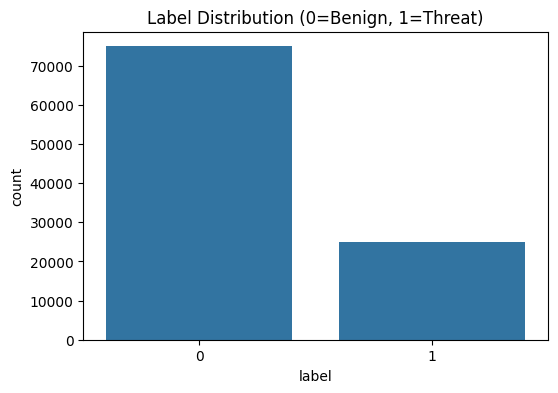

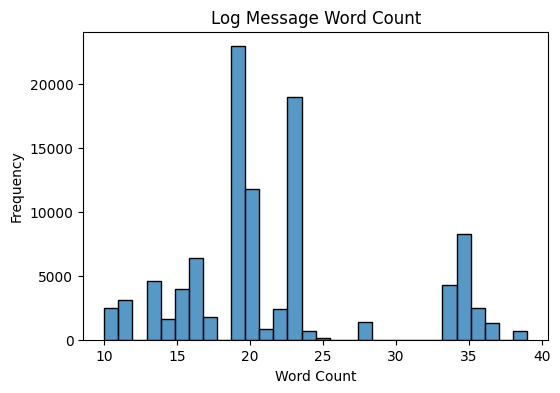

In [7]:
# ----------------------------------------------------
# F. EXPLORATORY VISUALIZATIONS
# ----------------------------------------------------
# 1. Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution (0=Benign, 1=Threat)')
plt.show()
# 2. Log message length distribution
df['log_len'] = df['clean_log'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df['log_len'], bins=30)
plt.title('Log Message Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [8]:
# ----------------------------------------------------
# G. FEATURE & LABEL SETUP
# ----------------------------------------------------
X = df['clean_log']
y = df['label']


In [9]:
# ----------------------------------------------------
# H. TRAIN/TEST SPLIT
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
# ----------------------------------------------------
# I. DEFINE MODELS
# ----------------------------------------------------
models = {
    # 'LogisticRegression': LogisticRegression(max_iter=1000),
    # 'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100)
    # 'GradientBoosting': GradientBoostingClassifier(),
    # 'SVM': SVC(probability=True)
}



RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     14997
           1       0.98      0.73      0.84      5003

    accuracy                           0.93     20000
   macro avg       0.95      0.86      0.90     20000
weighted avg       0.93      0.93      0.93     20000



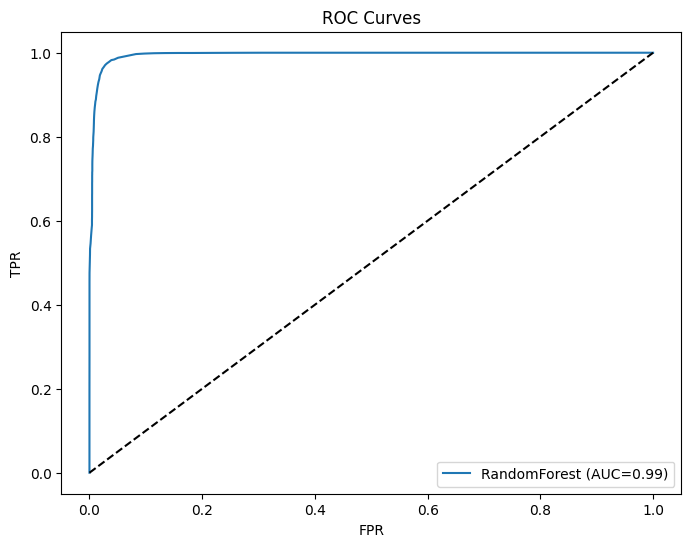

In [11]:
# ----------------------------------------------------
# J. TRAIN, EVALUATE & ROC PLOTTING
# ----------------------------------------------------
plt.figure(figsize=(8,6))
for name, clf in models.items():
    pipe = Pipeline([('tfidf', TfidfVectorizer()), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [12]:

# ----------------------------------------------------
# K. HYPERPARAMETER TUNING (OPTIONAL)
# ----------------------------------------------------
param_grid = {
    'clf__n_estimators': [50,100],
    'clf__max_depth': [None,10,20]
}
grid = GridSearchCV(
    Pipeline([('tfidf', TfidfVectorizer()),('clf',RandomForestClassifier())]),
    param_grid, cv=3, scoring='roc_auc'
)
grid.fit(X_train, y_train)
print('Best Params:', grid.best_params_)

Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100}


In [13]:
# ----------------------------------------------------
# L. RETRAIN BEST MODEL
# ----------------------------------------------------
best_params = {k.split('__')[1]: v for k, v in grid.best_params_.items()}
best_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(**best_params))
])
best_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [ ]:
# ----------------------------------------------------
# M. SAVE MODEL
# ----------------------------------------------------
import joblib
joblib.dump(best_model, 'best_insider_model.pkl')

['best_insider_model.pkl']

In [45]:
# ----------------------------------------------------
# N. INFERENCE FUNCTION
# ----------------------------------------------------
def classify_log(log_str):
    clean = preprocess_text(log_str)
    pred = best_model.predict([clean])[0]
    proba = best_model.predict_proba([clean])[0][pred]
    label = 'Insider Threat' if pred==1 else 'Benign'
    return {'prediction':label,'confidence':round(proba,2)}
    # return {'raw': log_str, 'cleaned': clean, 'prediction': label, 'confidence': round(proba, 2)}

# Example
example = "Jul 27 21:58:20 srv03 sshd[493019]: Failed password for root from 237.193.79.189 port 49499 ssh2"
print(classify_log(example))

{'prediction': 'Insider Threat', 'confidence': np.float64(1.0)}
